Jonathan Chan (34466219), Erick Jovan Muljadi (96641055), Katie Swangard (13265202), Aurora Wang (47454038)

DSCI 100 004

29 October 2022

Group Project Proposal

In [1]:
# Loading in necessary libraries:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

**Background Information**

ATP is a worldwide top-tier tennis tour for men organized by the Association of Tennis Professionals.  The question we are trying to ask is: based on three given characteristics of a new player (height, age and hand use), what ATP ranking will he achieve on each of the three different surfaces?  

We will use the dataset "Match Results for Top 500 Players 2017-2019". This data set includes the game statistics from 2017-2019 tournaments. It contains the ranking, results and match statistics of the top 500 players in the ATP, as well as individual characteristics of the winners and losers of each match, such as height, age, and hand use. 



In [2]:
# Reading in our dataset:
tennis <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")|>
    rename("ID_num" = 1)
# As the whole dataset would be too large to display, we are only displaying the first 10 rows here.
head(tennis, 10)

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ID_num,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
5,2019-M020,Brisbane,Hard,32,A,20181231,295,104871,NA,⋯,54,40,18,15,6,9,40,1050,185,275
6,2019-M020,Brisbane,Hard,32,A,20181231,294,105453,2,⋯,53,37,13,12,6,9,9,3590,19,1835
7,2019-M020,Brisbane,Hard,32,A,20181231,293,104542,NA,⋯,51,34,11,11,6,11,239,200,77,691
8,2019-M020,Brisbane,Hard,32,A,20181231,292,200282,7,⋯,39,30,3,9,3,6,31,1298,72,715


In [3]:
# Selecting only for rows needed in our data analysis:
tennis_smaller <- tennis|>
    select(ID_num,winner_hand,winner_ht,winner_age, winner_rank,surface, loser_hand,loser_ht, loser_age, loser_rank)|>
    mutate(ID_num = as_factor(ID_num), winner_hand = as_factor(winner_hand)) # Mutating ID_num and winner_hand into factor columns.
# Combining winner and loser data into one column:
tennis_pivot <- tennis_smaller |>
    pivot_longer(cols = c("winner_rank", "loser_rank"),
                     names_to = "wol_rank",
                     values_to = "rank") |>
    pivot_longer(cols = c("winner_ht", "loser_ht"),
                     names_to = "wol_height",
                     values_to = "height") |>
    pivot_longer(cols = c("winner_age", "loser_age"),
                     names_to = "wol_age",
                     values_to = "age") |>
    pivot_longer(cols = c("winner_hand", "loser_hand"),
                     names_to = "wol_hand",
                     values_to = "hand")
tennis_pivot |>
    slice(1 : 10) # Displaying the top 10 columns.

ID_num,surface,wol_rank,rank,wol_height,height,wol_age,age,wol_hand,hand
<fct>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
0,Hard,winner_rank,9,winner_ht,178,winner_age,29.00479,winner_hand,R
0,Hard,winner_rank,9,winner_ht,178,winner_age,29.00479,loser_hand,R
0,Hard,winner_rank,9,winner_ht,178,loser_age,22.88569,winner_hand,R
0,Hard,winner_rank,9,winner_ht,178,loser_age,22.88569,loser_hand,R
0,Hard,winner_rank,9,loser_ht,NA,winner_age,29.00479,winner_hand,R
0,Hard,winner_rank,9,loser_ht,NA,winner_age,29.00479,loser_hand,R
0,Hard,winner_rank,9,loser_ht,NA,loser_age,22.88569,winner_hand,R
0,Hard,winner_rank,9,loser_ht,NA,loser_age,22.88569,loser_hand,R
0,Hard,loser_rank,16,winner_ht,178,winner_age,29.00479,winner_hand,R


In [4]:
# Groupping by rank, surface, and hand, then finding mean height and age.
tennis_mean <- tennis_pivot|>
    group_by(rank, surface, hand) |>
    summarize(mean_ht = mean(height, na.rm = TRUE), mean_age = mean(age))
# Displaying only the top 10 columns due to space constraints:
head(tennis_mean, 10)

`summarise()` has grouped output by 'rank', 'surface'. You can override using
the `.groups` argument.


rank,surface,hand,mean_ht,mean_age
<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,Clay,L,185.3214,29.61405
1,Clay,R,186.9524,29.13028
1,Grass,L,185.5833,29.47793
1,Grass,R,186.3857,30.47293
1,Hard,L,186.3253,29.04523
1,Hard,R,187.4488,29.58200
1,Hard,U,185.0000,27.59069
2,Clay,L,184.8364,30.37757
2,Clay,R,185.2842,29.35792


In [5]:
# Splitting our data 75/25 into training and testing data:
tennis_split <- initial_split(tennis_mean, prop = 0.75, strata = rank )
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

In [6]:
tennis_training

rank,surface,hand,mean_ht,mean_age
<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,Clay,L,185.3214,29.61405
1,Clay,R,186.9524,29.13028
1,Grass,L,185.5833,29.47793
1,Grass,R,186.3857,30.47293
1,Hard,L,186.3253,29.04523
1,Hard,R,187.4488,29.58200
1,Hard,U,185.0000,27.59069
2,Clay,L,184.8364,30.37757
2,Clay,R,185.2842,29.35792


Warning message:
“Removed 4 rows containing missing values (geom_point).”
Warning message:
“Removed 160 rows containing missing values (geom_point).”


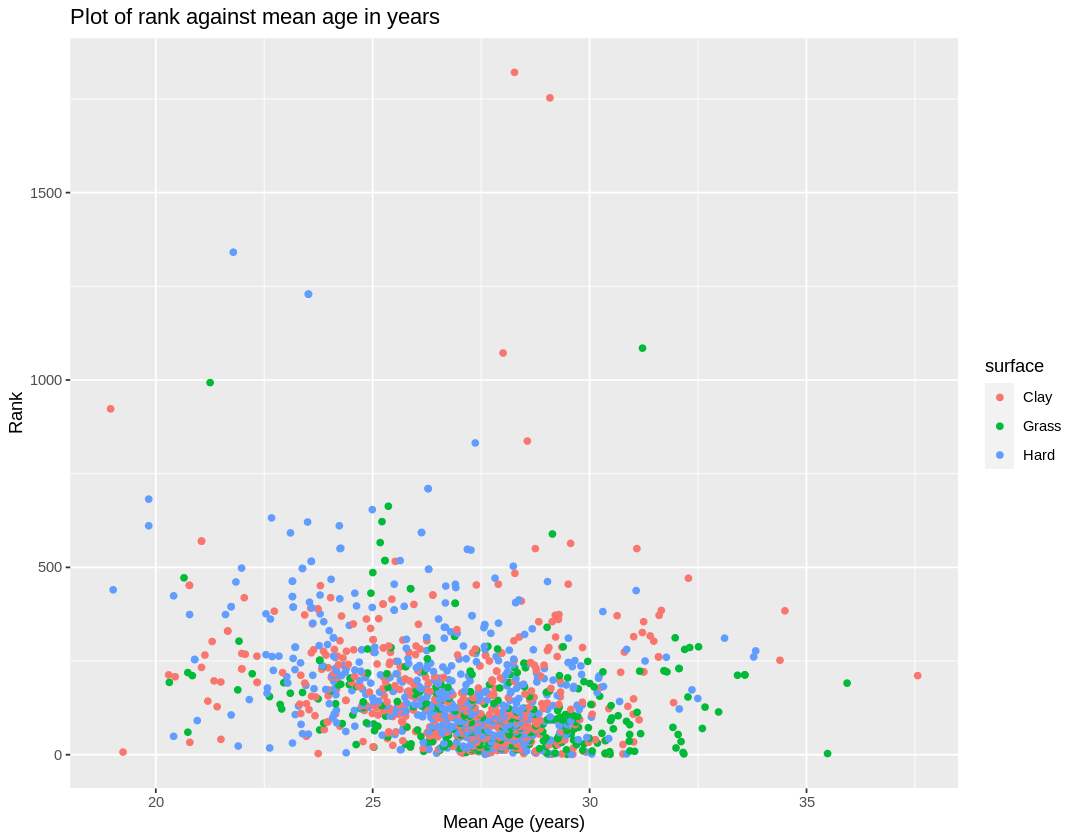

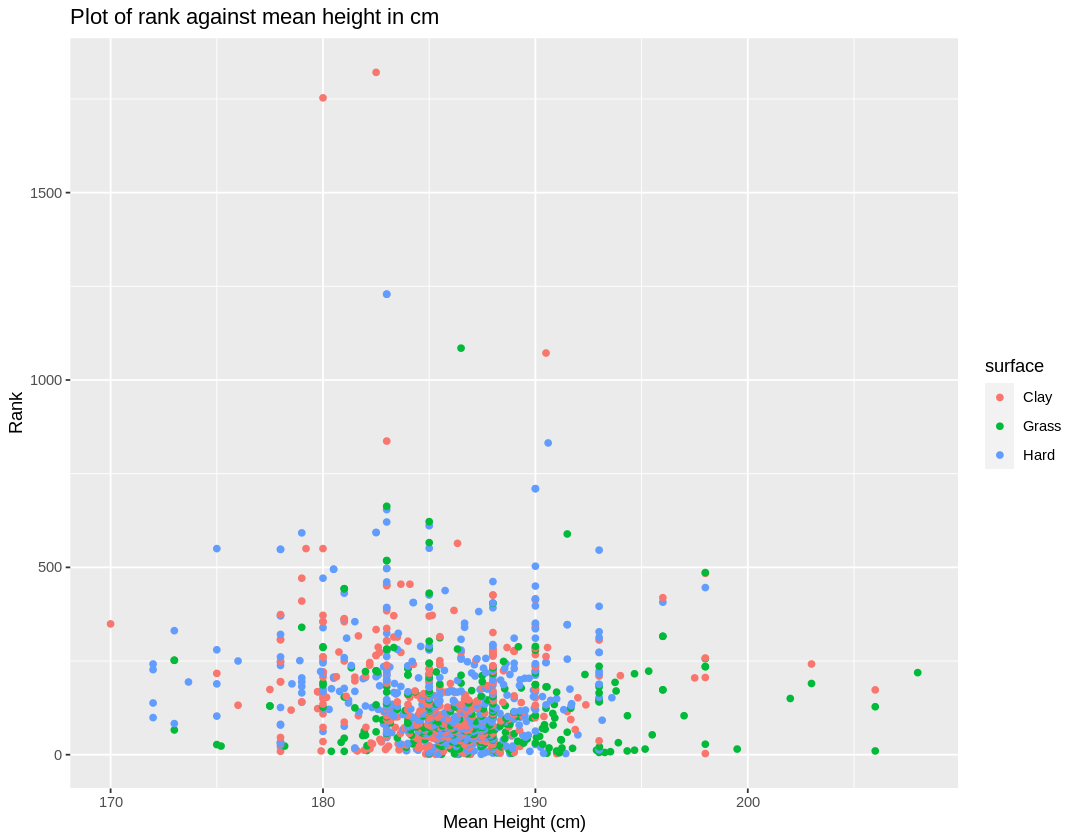

In [10]:
# Plotting rank against mean age:
options(repr.plot.width = 9, repr.plot.height = 7)
rank_vs_age_plot <- tennis_training|>
    filter(surface == "Clay"| surface == "Grass"| surface == "Hard")|>
    ggplot(aes(x=mean_age, y=rank, colour = surface))+
    geom_point() +
    labs(x = "Mean Age (years)", y = "Rank") +
    ggtitle("Plot of rank against mean age in years")
rank_vs_age_plot
#
# use facet_grid
#
# Plotting height against mean age:
rank_vs_height_plot<- tennis_training|>
    filter(surface == "Clay"| surface == "Grass"| surface == "Hard")|>
    ggplot(aes(x=mean_ht, y=rank, colour = surface))+
    geom_point() +
    labs(x = "Mean Height (cm)", y = "Rank") +
    ggtitle("Plot of rank against mean height in cm")
rank_vs_height_plot

In [9]:
# Creating a workflow for further data analysis and prediction using regression:
tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
                  set_engine("kknn") |>
                  set_mode("regression") 

tennis_recipe <- recipe(rank ~ mean_ht + mean_age, data = tennis_training) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

tennis_workflow <- workflow() |>
                    add_recipe(tennis_recipe) |>
                    add_model(tennis_spec)
tennis_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


**Methods**

We will use the variables mentioned above to predict a new player’s rank. After splitting the data into testing and training sets (75/25 split), we will use cross-validation and regression to first find the best value of K for our k-nearest neighbours model. We will then fit our training data to this model and attempt to predict the ranks for our testing data.  Afterwards, we will compare the true ranks to those estimated by our model and determine the model’s accuracy using RMSE. If the RMSE of the training set and the testing set are similar, then our model should be suitable. 

Next, we’ll input a new player’s height, age, and preferred hand and find the new player’s rank using our model. Then, we can make 2 plots with winner_rank vs winner_height and winner_rank vs winner_age with the new player’s data to visualise the data. 



**Expected Outcomes:**

We should be able to predict the rank of a new player with reasonable accuracy, as we believe the predictors that we have chosen are good indicators of ability. Furthermore, we expect to find that the surface each game is played on will affect the predicted rank of a new player. This is because players often have more practice on specific types of courts, which would affect their performance in the game.  We may run a secondary analysis to investigate this.

The impacts of such findings are profound: as seen in this dataset, tennis players with a higher rank often win against players of lower rank. By predicting the rank of an unknown player, we are able to roughly predict the outcome of a tennis game before it is played. This has repercussions in the field of tennis, and also in sports gambling and fantasy sports. 

As to the impacts of our secondary hypothesis, if players find that they are underperforming on certain courts, they could practice more on those types and improve their rank. Therefore our data can also help tennis players improve their abilities and earnings.

One additional question that could arise from this data analysis is whether the same results apply to the top 500 female players. Female tennis is one of the most watched female sports in the world, and if the same results apply to it, then all the impacts discussed above would also apply there.

